In [1]:
# 1) Gerekli Temel Kütüphaneler
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
import joblib

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation,
    MaxPooling1D, Dropout, concatenate, LSTM, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

# Bu hücreyi çalıştırdıktan sonra aşağıdaki tüm kütüphane ve metrikler hazır olacak.


In [3]:
# 2.1. Excel dosyasını oku
df = pd.read_excel("features_labeled.xlsx", engine="openpyxl")

# 2.2. Tarih sütununu datetime türüne çevir
df["Date"] = pd.to_datetime(df["Date"])

# 2.3. Hangi tickers (hisseler) var? (Örn: ["BIMAS","EKGYO", ...])
tickers = df["Stock"].unique().tolist()
print(f"Bulunan ticker sayısı: {len(tickers)} → {tickers[:5]} ...")


Bulunan ticker sayısı: 8 → ['MPARK', 'GARAN', 'BIMAS', 'EREGL', 'TCELL'] ...


In [9]:
def split_stock_chronological(stock_df, train_frac=0.70, val_frac=0.15):
    """
    Bir hisseye ait DataFrame'i (zaman sıralı) train, validation, test olarak böler.
    Args:
      stock_df: Tarih sıralı, tek bir hisseye ait DataFrame
      train_frac: Train set oranı (örneğin 0.70)
      val_frac:   Validation set oranı (örneğin 0.15)
      test_frac:  Kalan oran (1 - train_frac - val_frac)
    Returns:
      train_df, val_df, test_df  (pandas DataFrame)
    """
    n = len(stock_df)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))
    
    train_df = stock_df.iloc[:train_end].copy()
    val_df = stock_df.iloc[train_end:val_end].copy()
    test_df = stock_df.iloc[val_end:].copy()
    
    return train_df, val_df, test_df


In [11]:
def scale_stock_data(train_df, val_df, test_df):
    """
    Args:
      train_df, val_df, test_df: Aynı hisseye ait DataFrame
    Returns:
      scaled_train, scaled_val, scaled_test: 
        Her biri dict, anahtar: "ema", "kalman", "kama", "hlcv", değer: numpy array
      scalers: {"ema_scaler":…, "kalman_scaler":…, "kama_scaler":…, "hlcv_scaler":…}
    """
    # 1) Scaler objeleri
    ema_scaler    = MinMaxScaler()
    kalman_scaler = MinMaxScaler()
    kama_scaler   = MinMaxScaler()
    hlcv_scaler   = MinMaxScaler()

    # 2) Her grup için X_train, X_val, X_test al
    #    (a) EMA grubu (7 sütun)
    X_train_ema    = train_df[["EMA_8","EMA_13","EMA_21","EMA_34","EMA_55","EMA_89","EMA_144"]].values
    X_val_ema      = val_df[["EMA_8","EMA_13","EMA_21","EMA_34","EMA_55","EMA_89","EMA_144"]].values
    X_test_ema     = test_df[["EMA_8","EMA_13","EMA_21","EMA_34","EMA_55","EMA_89","EMA_144"]].values
    ema_scaler.fit(X_train_ema)
    E_train = ema_scaler.transform(X_train_ema)
    E_val   = ema_scaler.transform(X_val_ema)
    E_test  = ema_scaler.transform(X_test_ema)

    #    (b) KALMAN grubu (2 sütun)
    X_train_kalman = train_df[["kalman_short","kalman_long"]].values
    X_val_kalman   = val_df[["kalman_short","kalman_long"]].values
    X_test_kalman  = test_df[["kalman_short","kalman_long"]].values
    kalman_scaler.fit(X_train_kalman)
    K_train = kalman_scaler.transform(X_train_kalman)
    K_val   = kalman_scaler.transform(X_val_kalman)
    K_test  = kalman_scaler.transform(X_test_kalman)

    #    (c) KAMA grubu (4 sütun)
    X_train_kama = train_df[["kama_13","kama_21","kama_34","kama_55"]].values
    X_val_kama   = val_df[["kama_13","kama_21","kama_34","kama_55"]].values
    X_test_kama  = test_df[["kama_13","kama_21","kama_34","kama_55"]].values
    kama_scaler.fit(X_train_kama)
    Ka_train = kama_scaler.transform(X_train_kama)
    Ka_val   = kama_scaler.transform(X_val_kama)
    Ka_test  = kama_scaler.transform(X_test_kama)

    #    (d) HLCV-XU100 grubu (5 sütun)
    X_train_hlcv = train_df[["High","Low","Close","Volume","XU100"]].values
    X_val_hlcv   = val_df[["High","Low","Close","Volume","XU100"]].values
    X_test_hlcv  = test_df[["High","Low","Close","Volume","XU100"]].values
    hlcv_scaler.fit(X_train_hlcv)
    H_train = hlcv_scaler.transform(X_train_hlcv)
    H_val   = hlcv_scaler.transform(X_val_hlcv)
    H_test  = hlcv_scaler.transform(X_test_hlcv)

    # 3) “scaled_dict” yapısını oluştur
    scaled_train = {
        "ema":    E_train,       # (n_train, 7)
        "kalman": K_train,       # (n_train, 2)
        "kama":   Ka_train,      # (n_train, 4)
        "hlcv":   H_train        # (n_train, 5)
    }
    scaled_val = {
        "ema":    E_val,
        "kalman": K_val,
        "kama":   Ka_val,
        "hlcv":   H_val
    }
    scaled_test = {
        "ema":    E_test,
        "kalman": K_test,
        "kama":   Ka_test,
        "hlcv":   H_test
    }

    # 4) Scaler nesnelerini bir dict’te tut
    scalers = {
        "ema_scaler":    ema_scaler,
        "kalman_scaler": kalman_scaler,
        "kama_scaler":   kama_scaler,
        "hlcv_scaler":   hlcv_scaler
    }

    return scaled_train, scaled_val, scaled_test, scalers


In [13]:
def create_sequences_with_meta_simple(scaled_dict, date_array, label_array, stock_name, seq_len=60):
    """
    Sadeleştirilmiş versiyon: Sadece satır sayısına bakarak ardışık pencere oluşturur.
    Args:
      scaled_dict:  {"ema":(n,7), "kalman":(n,2), "kama":(n,4), "hlcv":(n,5)}
      date_array:   np.array of shape (n,) (örn. train_df['Date'].values)
      label_array:  np.array of shape (n,) (örn. train_df['label'].values)
      stock_name:   Hisse kodu (örn. "BIMAS")
      seq_len:      Pencere uzunluğu (default=60)
    Returns:
      [X_ema, X_kalman, X_kama, X_hlcv],  y_seq, dates_seq, stocks_seq
      - X_ema: (n_seq, seq_len, 7)
      - X_kalman: (n_seq, seq_len, 2)
      - X_kama: (n_seq, seq_len, 4)
      - X_hlcv: (n_seq, seq_len, 5)
      - y_seq: (n_seq,)  → etiketler
      - dates_seq: (n_seq,) → pencerenin “son günü”nün tarihi
      - stocks_seq: (n_seq,) → aynı stock_name tekrarlanmış
    """
    X_ema, X_kalman, X_kama, X_hlcv = [], [], [], []
    y_seq = []
    dates_seq = []
    stocks_seq = []
    
    for i in range(seq_len, len(label_array)):
        start, end = i - seq_len, i
        X_ema.append(    scaled_dict['ema'][start:end, :] )
        X_kalman.append(scaled_dict['kalman'][start:end, :])
        X_kama.append(  scaled_dict['kama'][start:end, :] )
        X_hlcv.append(  scaled_dict['hlcv'][start:end, :] )
        
        y_seq.append(label_array[i])
        dates_seq.append(date_array[i])
        stocks_seq.append(stock_name)
    
    # Numpy dizilerine dönüştür
    X_ema    = np.array(X_ema)
    X_kalman = np.array(X_kalman)
    X_kama   = np.array(X_kama)
    X_hlcv   = np.array(X_hlcv)
    y_seq    = np.array(y_seq)
    dates_seq  = np.array(dates_seq)
    stocks_seq = np.array(stocks_seq)
    
    return [X_ema, X_kalman, X_kama, X_hlcv], y_seq, dates_seq, stocks_seq


In [15]:
# 4.1. Boş listeler: TRAIN
X_tr_ema_list,    X_tr_kalman_list,    X_tr_kama_list,    X_tr_hlcv_list = [], [], [], []
y_tr_list,        dates_tr_list,        stocks_tr_list       = [], [], []

# 4.2. Boş listeler: VALIDATION
X_va_ema_list,    X_va_kalman_list,    X_va_kama_list,    X_va_hlcv_list = [], [], [], []
y_va_list,        dates_va_list,        stocks_va_list       = [], [], []

# 4.3. Boş listeler: TEST
X_te_ema_list,    X_te_kalman_list,    X_te_kama_list,    X_te_hlcv_list = [], [], [], []
y_te_list,        dates_te_list,        stocks_te_list       = [], [], []

# 4.4. Döngü: Her bir hisse (ticker) için split → scale → sequence üret
for ticker in tickers:
    # 4.4.1. Hisse verisini al ve Train/Val/Test split
    stock_df = df[df['Stock'] == ticker].copy().reset_index(drop=True)
    train_df, val_df, test_df = split_stock_chronological(stock_df)

    # 4.4.2. Ölçekleme (train_df’e fit, val_df/test_df’a transform)
    scaled_tr, scaled_va, scaled_te, scalers = scale_stock_data(train_df, val_df, test_df)

    # 4.4.3. Sadece ilk ticker için scaler'ları kaydet
    if ticker == tickers[0]:
        joblib.dump(scalers["ema_scaler"],    "scaler_ema.pkl")
        joblib.dump(scalers["kalman_scaler"], "scaler_kalman.pkl")
        joblib.dump(scalers["kama_scaler"],   "scaler_kama.pkl")
        joblib.dump(scalers["hlcv_scaler"],   "scaler_hlcv.pkl")

    # 4.4.4. Train/Val/Test için label ve tarih dizilerini al
    labels_tr = train_df['label'].values
    dates_tr  = train_df['Date'].values
    labels_va = val_df['label'].values
    dates_va  = val_df['Date'].values
    labels_te = test_df['label'].values
    dates_te  = test_df['Date'].values

    # 4.4.5. TRAIN için sequence + meta üret
    X_tr_grups, y_tr_seq, dates_tr_seq, stocks_tr_seq = create_sequences_with_meta_simple(
        scaled_tr, dates_tr, labels_tr, stock_name=ticker, seq_len=60
    )
    print(f"{ticker} → Train sequence sayısı: {len(y_tr_seq)}")
    X_tr_ema_list.append(   X_tr_grups[0] )
    X_tr_kalman_list.append(X_tr_grups[1] )
    X_tr_kama_list.append(  X_tr_grups[2] )
    X_tr_hlcv_list.append(  X_tr_grups[3] )
    y_tr_list.append(       y_tr_seq )
    dates_tr_list.append(   dates_tr_seq )
    stocks_tr_list.append(  stocks_tr_seq )

    # 4.4.6. VALIDATION için sequence + meta üret
    X_va_grups, y_va_seq, dates_va_seq, stocks_va_seq = create_sequences_with_meta_simple(
        scaled_va, dates_va, labels_va, stock_name=ticker, seq_len=60
    )
    print(f"{ticker} → Val sequence sayısı:   {len(y_va_seq)}")
    X_va_ema_list.append(   X_va_grups[0] )
    X_va_kalman_list.append(X_va_grups[1] )
    X_va_kama_list.append(  X_va_grups[2] )
    X_va_hlcv_list.append(  X_va_grups[3] )
    y_va_list.append(       y_va_seq )
    dates_va_list.append(   dates_va_seq )
    stocks_va_list.append(  stocks_va_seq )

    # 4.4.7. TEST için sequence + meta üret
    X_te_grups, y_te_seq, dates_te_seq, stocks_te_seq = create_sequences_with_meta_simple(
        scaled_te, dates_te, labels_te, stock_name=ticker, seq_len=60
    )
    print(f"{ticker} → Test sequence sayısı:  {len(y_te_seq)}")
    print("-" * 60)
    X_te_ema_list.append(   X_te_grups[0] )
    X_te_kalman_list.append(X_te_grups[1] )
    X_te_kama_list.append(  X_te_grups[2] )
    X_te_hlcv_list.append(  X_te_grups[3] )
    y_te_list.append(       y_te_seq )
    dates_te_list.append(   dates_te_seq )
    stocks_te_list.append(  stocks_te_seq )

# → Döngü sonu


MPARK → Train sequence sayısı: 1020
MPARK → Val sequence sayısı:   171
MPARK → Test sequence sayısı:  172
------------------------------------------------------------
GARAN → Train sequence sayısı: 1020
GARAN → Val sequence sayısı:   171
GARAN → Test sequence sayısı:  172
------------------------------------------------------------
BIMAS → Train sequence sayısı: 998
BIMAS → Val sequence sayısı:   167
BIMAS → Test sequence sayısı:  167
------------------------------------------------------------
EREGL → Train sequence sayısı: 993
EREGL → Val sequence sayısı:   166
EREGL → Test sequence sayısı:  166
------------------------------------------------------------
TCELL → Train sequence sayısı: 1008
TCELL → Val sequence sayısı:   169
TCELL → Test sequence sayısı:  170
------------------------------------------------------------
EKGYO → Train sequence sayısı: 1001
EKGYO → Val sequence sayısı:   167
EKGYO → Test sequence sayısı:  168
------------------------------------------------------------


In [17]:
# 5.1. Train setini concatenate et
X_train_ema    = np.concatenate(X_tr_ema_list,    axis=0)  # (toplam_train_seqs, 60, 7)
X_train_kalman = np.concatenate(X_tr_kalman_list, axis=0)  # (toplam_train_seqs, 60, 2)
X_train_kama   = np.concatenate(X_tr_kama_list,   axis=0)  # (toplam_train_seqs, 60, 4)
X_train_hlcv   = np.concatenate(X_tr_hlcv_list,   axis=0)  # (toplam_train_seqs, 60, 5)
y_train        = np.concatenate(y_tr_list,        axis=0)  # (toplam_train_seqs,)
dates_train    = np.concatenate(dates_tr_list,    axis=0)  # (toplam_train_seqs,)
stocks_train   = np.concatenate(stocks_tr_list,   axis=0)  # (toplam_train_seqs,)

# 5.2. Validation setini concatenate et
X_val_ema    = np.concatenate(X_va_ema_list,    axis=0)
X_val_kalman = np.concatenate(X_va_kalman_list, axis=0)
X_val_kama   = np.concatenate(X_va_kama_list,   axis=0)
X_val_hlcv   = np.concatenate(X_va_hlcv_list,   axis=0)
y_val        = np.concatenate(y_va_list,        axis=0)
dates_val    = np.concatenate(dates_va_list,    axis=0)
stocks_val   = np.concatenate(stocks_va_list,   axis=0)

# 5.3. Test setini concatenate et
X_test_ema    = np.concatenate(X_te_ema_list,    axis=0)
X_test_kalman = np.concatenate(X_te_kalman_list, axis=0)
X_test_kama   = np.concatenate(X_te_kama_list,   axis=0)
X_test_hlcv   = np.concatenate(X_te_hlcv_list,   axis=0)
y_test        = np.concatenate(y_te_list,        axis=0)
dates_test    = np.concatenate(dates_te_list,    axis=0)
stocks_test   = np.concatenate(stocks_te_list,   axis=0)

# 5.4. Boyut Kontrolü
print("→ X_train_ema shape:   ", X_train_ema.shape)
print("→ y_train shape:       ", y_train.shape)
print("→ dates_train shape:   ", dates_train.shape)
print("→ stocks_train shape:  ", stocks_train.shape)

print("→ X_val_ema shape:     ", X_val_ema.shape)
print("→ y_val shape:         ", y_val.shape)

print("→ X_test_ema shape:    ", X_test_ema.shape)
print("→ y_test shape:        ", y_test.shape)


→ X_train_ema shape:    (8063, 60, 7)
→ y_train shape:        (8063,)
→ dates_train shape:    (8063,)
→ stocks_train shape:   (8063,)
→ X_val_ema shape:      (1350, 60, 7)
→ y_val shape:          (1350,)
→ X_test_ema shape:     (1355, 60, 7)
→ y_test shape:         (1355,)


In [19]:
# 6.1. Model parametreleri
seq_len = 60
ema_channels    = 7
kalman_channels = 2
kama_channels   = 4
hlcv_channels   = 5
l2_reg = 1e-4
drop_rate = 0.4

# 6.2. Düzenlenmiş CNN bloğu (Conv1D + L2 + BatchNorm + Dropout)
def create_cnn_block_reg(input_shape, filters=[32, 64], kernel_size=3, pool_size=2):
    """
    Args:
      input_shape:  (seq_len, n_channels)
      filters:      Liste, her Conv1D katmanı için filtre sayısı (ör. [32,64])
      kernel_size:  Conv1D kernel boyutu (ör. 3)
      pool_size:    MaxPooling1D havuz boyutu (ör. 2)
    Returns:
      Keras Model: input_shape → (batch, reduced_time, filter_sayıları toplamı)
    """
    inp = Input(shape=input_shape)
    x = inp
    
    for f in filters:
        # (1) Conv1D + L2 regularization
        x = Conv1D(
            filters=f,
            kernel_size=kernel_size,
            padding='same',
            kernel_regularizer=l2(l2_reg)
        )(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # (2) Pooling
        x = MaxPooling1D(pool_size=pool_size)(x)
        
        # (3) Dropout
        x = Dropout(drop_rate)(x)
    
    return Model(inputs=inp, outputs=x)

# 6.3. Her grup için ayrı CNN blokları
cnn_ema    = create_cnn_block_reg((seq_len, ema_channels),    filters=[32, 64], pool_size=2)
cnn_kalman = create_cnn_block_reg((seq_len, kalman_channels), filters=[16, 32], pool_size=2)
cnn_kama   = create_cnn_block_reg((seq_len, kama_channels),   filters=[16, 32], pool_size=2)
cnn_hlcv   = create_cnn_block_reg((seq_len, hlcv_channels),   filters=[32, 64], pool_size=2)

# 6.4. Girdi katmanları
inp_ema    = Input(shape=(seq_len, ema_channels),    name='inp_ema')
inp_kalman = Input(shape=(seq_len, kalman_channels), name='inp_kalman')
inp_kama   = Input(shape=(seq_len, kama_channels),   name='inp_kama')
inp_hlcv   = Input(shape=(seq_len, hlcv_channels),   name='inp_hlcv')

# 6.5. CNN çıktıları (örneğin: (batch, 15, 64) vb.)
feat_ema    = cnn_ema(inp_ema)        # (batch, 15, 64)
feat_kalman = cnn_kalman(inp_kalman)  # (batch, 15, 32)
feat_kama   = cnn_kama(inp_kama)      # (batch, 15, 32)
feat_hlcv   = cnn_hlcv(inp_hlcv)      # (batch, 15, 64)

# 6.6. CNN çıktılarını birleştirme (Concatenate)
merged = concatenate([feat_ema, feat_kalman, feat_kama, feat_hlcv], axis=-1)
# merged shape ≈ (batch, 15, 64+32+32+64 = 192)

# 6.7. Çift katmanlı LSTM (ilk katmanda return_sequences=True)
lstm1 = LSTM(
    units=128,
    return_sequences=True,
    kernel_regularizer=l2(l2_reg),
    recurrent_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg)
)(merged)
lstm1 = Dropout(drop_rate)(lstm1)

lstm2 = LSTM(
    units=64,
    return_sequences=False,
    kernel_regularizer=l2(l2_reg),
    recurrent_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg)
)(lstm1)
lstm2 = Dropout(drop_rate)(lstm2)

# 6.8. Dense katman (+ L2 ve Dropout)
x = Dense(
    32,
    activation='relu',
    kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg)
)(lstm2)
x = Dropout(drop_rate)(x)

# 6.9. Çıkış katmanı
output = Dense(
    1,
    activation='sigmoid',
    kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg)
)(x)

# 6.10. Model tanımı ve derleme
model = Model(
    inputs=[inp_ema, inp_kalman, inp_kama, inp_hlcv],
    outputs=output
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 6.11. Model özeti
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inp_ema (InputLayer)          │ (None, 60, 7)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ inp_kalman (InputLayer)       │ (None, 60, 2)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ inp_kama (InputLayer)         │ (None, 60, 4)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ inp_hlcv (InputLayer)         │ (None, 60, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional (Functional)       │ (None, 15, 64)            │           7,296 │ inp_ema[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_1 (Functional)     │ (None, 15, 32)            │           1,872 │ inp_kalman[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_2 (Functional)     │ (None, 15, 32)            │           1,968 │ inp_kama[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_3 (Functional)     │ (None, 15, 64)            │           7,104 │ inp_hlcv[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 15, 192)           │               0 │ functional[0][0],          │
│                               │                           │                 │ functional_1[0][0],        │
│                               │                           │                 │ functional_2[0][0],        │
│                               │                           │                 │ functional_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 15, 128)           │         164,352 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 15, 128)           │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 64)                │          49,408 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 64)                │               0 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │           2,080 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 32)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              3

 Total params: 234,113 (914.50 KB)

 Trainable params: 233,537 (912.25 KB)

 Non-trainable params: 576 (2.25 KB)

In [21]:
# 7.1. Callback’ler
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
rlrop = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)
mc = ModelCheckpoint(
    'best_trend_model_reg.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 7.2. Sınıf Dengesizliği (Class Weights)
cw_vals = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(cw_vals))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.360614242321971), 1: np.float64(0.7904901960784314)}


In [23]:
history = model.fit(
    x={
        'inp_ema':    X_train_ema,
        'inp_kalman': X_train_kalman,
        'inp_kama':   X_train_kama,
        'inp_hlcv':   X_train_hlcv
    },
    y=y_train,
    validation_data=(
        {
            'inp_ema':    X_val_ema,
            'inp_kalman': X_val_kalman,
            'inp_kama':   X_val_kama,
            'inp_hlcv':   X_val_hlcv
        },
        y_val
    ),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[es, rlrop, mc]
)


Epoch 1/100
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5170 - loss: 0.8034 - precision: 0.6360 - recall: 0.5458
Epoch 1: val_loss improved from inf to 0.89523, saving model to best_trend_model_reg.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5169 - loss: 0.8033 - precision: 0.6361 - recall: 0.5455 - val_accuracy: 0.2689 - val_loss: 0.8952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5470 - loss: 0.7866 - precision: 0.6768 - recall: 0.5413
Epoch 2: val_loss did not improve from 0.89523
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5469 - loss: 0.7866 - precision: 0.6768 - recall: 0.5413 - val_accuracy: 0.2689 - val_loss: 0.9631 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5605 - loss: 0.7749 - precision: 0.7060 - recall: 0.5114
Epoch 3: val_loss did not improve from 0.89523
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5607 - loss: 0.7748 - precision: 0.7061 - recall: 0.5117 - val_accuracy: 0.2815 - val_loss: 1.0130 - val_precision: 1.0000 - val_rec

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6686 - loss: 0.7013 - precision: 0.7863 - recall: 0.6604 - val_accuracy: 0.5296 - val_loss: 0.8237 - val_precision: 0.8465 - val_recall: 0.4357 - learning_rate: 1.0000e-04
Epoch 6/100
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7160 - loss: 0.6421 - precision: 0.8287 - recall: 0.6962
Epoch 6: val_loss improved from 0.82374 to 0.77315, saving model to best_trend_model_reg.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7160 - loss: 0.6422 - precision: 0.8286 - recall: 0.6963 - val_accuracy: 0.6422 - val_loss: 0.7732 - val_precision: 0.8830 - val_recall: 0.5887 - learning_rate: 1.0000e-04
Epoch 7/100
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7332 - loss: 0.6295 - precision: 0.8255 - recall: 0.7327
Epoch 7: val_loss improved from 0.77315 to 0.64693, saving model to best_trend_model_reg.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7333 - loss: 0.6295 - precision: 0.8256 - recall: 0.7327 - val_accuracy: 0.7459 - val_loss: 0.6469 - val_precision: 0.8710 - val_recall: 0.7660 - learning_rate: 1.0000e-04
Epoch 8/100
248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7416 - loss: 0.6076 - precision: 0.8492 - recall: 0.7208
Epoch 8: val_loss did not improve from 0.64693
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7418 - loss: 0.6074 - precision: 0.8492 - recall: 0.7211 - val_accuracy: 0.7474 - val_loss: 0.6692 - val_precision: 0.8998 - val_recall: 0.7366 - learning_rate: 1.0000e-04
Epoch 9/100
246/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7659 - loss: 0.5868 - precision: 0.8585 - recall: 0.7550
Epoch 9: val_loss did not improve from 0.64693
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7658 - loss: 0.5869 - precision: 0.8584 - recall: 0.7549 - val_accuracy: 0.6830 - val_loss: 0.8135 - val_precision: 0.8987 - val_recall: 0.6383 - lea

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7876 - loss: 0.5455 - precision: 0.8718 - recall: 0.7771 - val_accuracy: 0.7630 - val_loss: 0.6270 - val_precision: 0.8928 - val_recall: 0.7680 - learning_rate: 5.0000e-05
Epoch 14/100
248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7896 - loss: 0.5404 - precision: 0.8674 - recall: 0.7902
Epoch 14: val_loss did not improve from 0.62701
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7896 - loss: 0.5405 - precision: 0.8674 - recall: 0.7900 - val_accuracy: 0.7474 - val_loss: 0.6761 - val_precision: 0.9007 - val_recall: 0.7356 - learning_rate: 5.0000e-05
Epoch 15/100
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7785 - loss: 0.5442 - precision: 0.8717 - recall: 0.7627
Epoch 15: val_loss did not improve from 0.62701
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7785 - loss: 0.5442 - precision: 0.8717 - recall: 0.7628 - val_accuracy: 0.7474 - val_loss: 0.6578 - val_precision: 0.8882 - val_recall: 0.7487 -

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7914 - loss: 0.5395 - precision: 0.8767 - recall: 0.7757 - val_accuracy: 0.7748 - val_loss: 0.6018 - val_precision: 0.9013 - val_recall: 0.7771 - learning_rate: 2.5000e-05
Epoch 23/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7938 - loss: 0.5368 - precision: 0.8712 - recall: 0.7875
Epoch 23: val_loss did not improve from 0.60178
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7938 - loss: 0.5367 - precision: 0.8713 - recall: 0.7875 - val_accuracy: 0.7659 - val_loss: 0.6248 - val_precision: 0.9047 - val_recall: 0.7599 - learning_rate: 2.5000e-05
Epoch 24/100
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7958 - loss: 0.5417 - precision: 0.8708 - recall: 0.7905
Epoch 24: val_loss did not improve from 0.60178
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7958 - loss: 0.5415 - precision: 0.8709 - recall: 0.7904 - val_accuracy: 0.7763 - val_loss: 0.6068 - val_precision: 0.9015 - val_recall: 0.7791 -

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7978 - loss: 0.5275 - precision: 0.8716 - recall: 0.7950 - val_accuracy: 0.7770 - val_loss: 0.6010 - val_precision: 0.9016 - val_recall: 0.7801 - learning_rate: 2.5000e-05
Epoch 26/100
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8051 - loss: 0.5153 - precision: 0.8858 - recall: 0.7929
Epoch 26: val_loss did not improve from 0.60097
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8051 - loss: 0.5153 - precision: 0.8859 - recall: 0.7928 - val_accuracy: 0.7637 - val_loss: 0.6309 - val_precision: 0.9063 - val_recall: 0.7548 - learning_rate: 2.5000e-05
Epoch 27/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7977 - loss: 0.5238 - precision: 0.8786 - recall: 0.7870
Epoch 27: val_loss did not improve from 0.60097
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7976 - loss: 0.5238 - precision: 0.8786 - recall: 0.7870 - val_accuracy: 0.7719 - val_loss: 0.6177 - val_precision: 0.9066 - val_recall: 0.7670 -

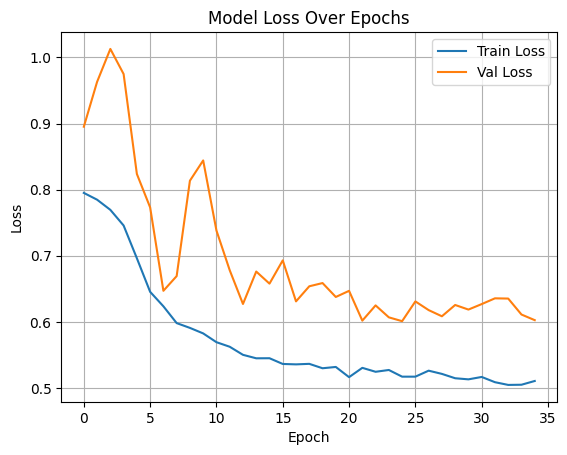

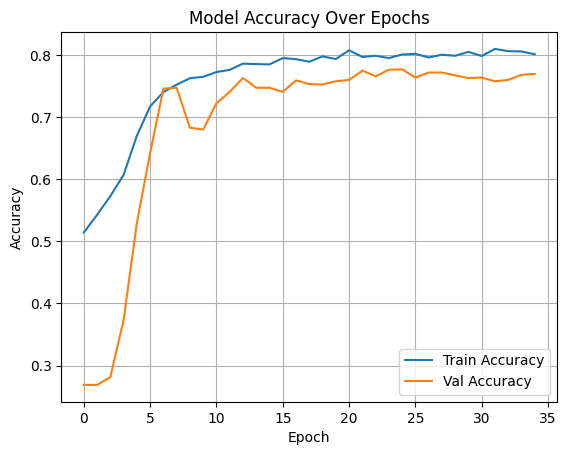

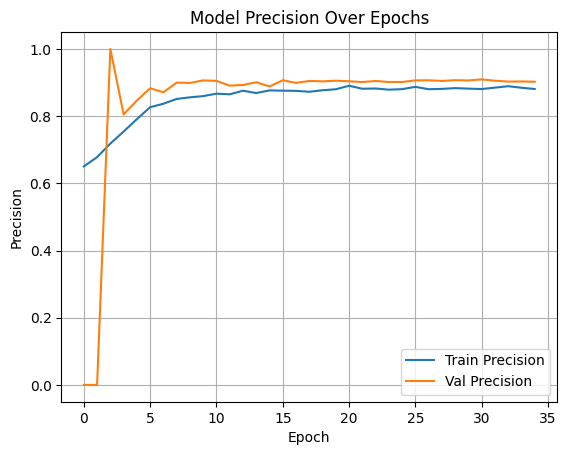

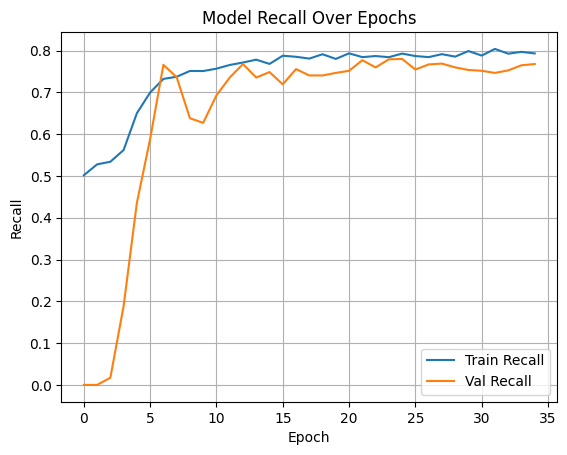

In [25]:
# 9.1. Eğitim ve Validation Loss Grafiği
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 9.2. Eğitim ve Validation Accuracy Grafiği
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 9.3. Eğitim ve Validation Precision Grafiği
plt.figure()
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Model Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# 9.4. Eğitim ve Validation Recall Grafiği
plt.figure()
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Model Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 10.1. Kaydedilen en iyi modeli yükle (ModelCheckpoint ile kaydedilen)
best_model = tf.keras.models.load_model("best_trend_model_reg.h5")

# 10.2. Test seti için olasılık tahminlerini al
y_pred_prob = best_model.predict(
    {
        'inp_ema':    X_test_ema,
        'inp_kalman': X_test_kalman,
        'inp_kama':   X_test_kama,
        'inp_hlcv':   X_test_hlcv
    }
).flatten()

# 10.3. 0.5 eşik ile 0/1 tahminine dönüştür
y_pred = (y_pred_prob >= 0.5).astype(int)

# 10.4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down','Up'])

#plt.figure()
#disp.plot(colorbar=False)
#plt.title('Confusion Matrix on Test Set')
#plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


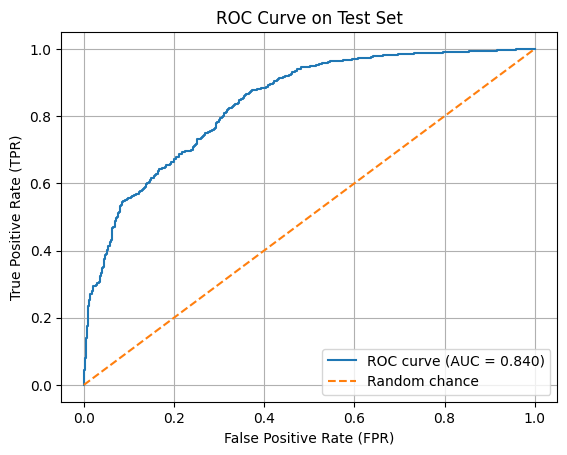

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

# 11.1. ROC eğrisi için fpr, tpr ve eşik değerler
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# 11.2. ROC eğrisini çiz
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
